In [2]:
import os
import sys

path = os.getcwd()
while os.path.basename(os.path.normpath(path)) != 'roman-pandeia':
    path = os.path.dirname(path)
repo_path = path
if repo_path not in sys.path:
    sys.path.append(repo_path)

In [3]:
import numpy as np
import time

from pprint import pprint
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['axes.grid'] = False
matplotlib.rcParams['image.origin'] = 'lower'

from pandeia.engine.perform_calculation import perform_calculation
from pandeia.engine.calc_utils import build_default_calc, build_default_source
from lenstronomy.Util import data_util
from lenstronomy.SimulationAPI.ObservationConfig.Roman import Roman

from package.helpers import test_physical_lens
from package.plots import plot, diagnostic_plot

/data/bwedig/.conda/envs/pandeia/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


In [4]:
oversample_factor_list = [1, 3, 5, 7, 9]
execution_time = []

figure_dir = os.path.join(repo_path, 'figures', 'diagnostics', 'pixel_density_test')
array_dir = os.path.join(repo_path, 'output', 'arrays', 'diagnostics', 'pixel_density_test')

lens = test_physical_lens.TestPhysicalLens()

In [5]:
lenstronomy_roman_config = Roman(band='F106', psf_type='PIXEL', survey_mode='wide_area').kwargs_single_band()
magnitude_zero_point = lenstronomy_roman_config.get('magnitude_zero_point')

In [15]:
for oversample_factor in oversample_factor_list:
    side = 5
    num_pix = 45 * oversample_factor

    image = lens.get_array(num_pix, side)

    plot.plot(filepath=os.path.join(figure_dir, f'model_{oversample_factor}.png'),
              title=f'Lenstronomy model\nOversampling factor {oversample_factor}', 
              array=image,
              colorbar=True)
    np.save(os.path.join(array_dir, f'model_{oversample_factor}'), image)

    print(f'Starting calculation for oversample factor {oversample_factor}')

    # start timer
    start = time.time()

    calc = build_default_calc('roman', 'wfi', 'imaging')

    # scene size settings
    calc['configuration']['dynamic_scene'] = True
    calc['configuration']['max_scene_size'] = 5

    # change filter
    calc['configuration']['instrument']['filter'] = 'f106'

    # convert brightnesses
    j = 0
    side, _ = image.shape
    mag_array = np.zeros(image.shape)

    for row_number, row in tqdm(enumerate(image), total=side):
        for item_number, item in enumerate(row):
            mag_array[row_number][item_number] = data_util.cps2magnitude(item, magnitude_zero_point)
            j += 1

    i = 0
    print('Converting to point sources...')
    for row_number, row in tqdm(enumerate(mag_array)):
        for item_number, item in enumerate(row):
            if i != 0:
                calc['scene'].append(build_default_source(geometry='point', telescope='roman'))

            # set brightness
            calc['scene'][i]['spectrum']['normalization']['norm_flux'] = item
            calc['scene'][i]['spectrum']['normalization']['norm_fluxunit'] = 'abmag'
            calc['scene'][i]['spectrum']['normalization']['norm_wave'] = 1.06
            calc['scene'][i]['spectrum']['normalization']['norm_waveunit'] = 'microns'
            calc['scene'][i]['spectrum']['normalization']['type'] = 'at_lambda'

            # set position
            calc['scene'][i]['position']['x_offset'] = (item_number * (1 / 9) * (
                        1 / oversample_factor)) + lens.ra_at_xy_0  # arcsec
            calc['scene'][i]['position']['y_offset'] = (row_number * (1 / 9) * (
                        1 / oversample_factor)) + lens.dec_at_xy_0  # arcsec

            i += 1
    print('Point source conversion complete')

    print('Performing Pandeia calculation...')
    results = perform_calculation(calc)
    print('Pandeia calculation complete')

    # stop timer
    stop = time.time()
    execution_time.append(stop - start)

    detector = results['2d']['detector']

    # TODO TEMP! flip image
    detector = np.flipud(detector)
    # detector = np.fliplr(detector)

    # save this numpy array
    np.save(os.path.join(array_dir, f'detector_{oversample_factor}'), detector)

    print(f'Finished calculation for oversample factor {oversample_factor}')

# save execution times
np.save(os.path.join(array_dir, 'execution_time'), execution_time)

100%|██████████| 45/45 [00:00<00:00, 11883.38it/s]


Converting to point sources...


45it [00:13,  3.41it/s]


Point source conversion complete
Performing Pandeia calculation...


/data/bwedig/.conda/envs/pandeia/lib/python3.9/site-packages/pandeia/engine/report.py:1012: RuntimeWarning: divide by zero encountered in log
  if np.log(abs(val)) < -1*precision and val != 0.0:
 20%|██        | 1/5 [03:10<12:43, 190.93s/it]

Pandeia calculation complete


100%|██████████| 135/135 [00:00<00:00, 3593.82it/s]


Converting to point sources...


135it [01:51,  1.21it/s]


Point source conversion complete
Performing Pandeia calculation...


 40%|████      | 2/5 [30:56<52:54, 1058.20s/it]

Pandeia calculation complete


100%|██████████| 225/225 [00:00<00:00, 2287.63it/s]


Converting to point sources...


225it [05:35,  1.49s/it]


Point source conversion complete
Performing Pandeia calculation...


 60%|██████    | 3/5 [1:51:05<1:32:22, 2771.17s/it]

Pandeia calculation complete


100%|██████████| 315/315 [00:00<00:00, 1675.94it/s]


Converting to point sources...


315it [11:35,  2.21s/it]


Point source conversion complete
Performing Pandeia calculation...
Pandeia calculation complete


100%|██████████| 405/405 [00:00<00:00, 1355.99it/s]


Converting to point sources...


405it [20:07,  2.98s/it]


Point source conversion complete
Performing Pandeia calculation...


100%|██████████| 5/5 [8:40:40<00:00, 6248.03s/it]  

Pandeia calculation complete


       2
191.7 x - 20.3 x + 23.57


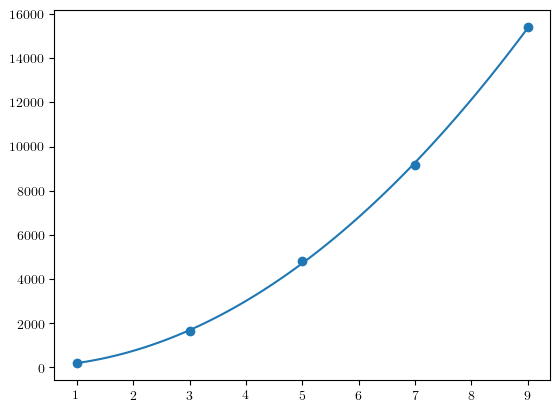

In [18]:
execution_time = np.load(os.path.join(array_dir, 'execution_time.npy'))
x = np.linspace(1, 9, len(execution_time))

# https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html
model = np.poly1d(np.polyfit(x, execution_time, 2))
poly_x = np.linspace(1, 9, 100)

print(model)

plt.scatter(x, execution_time)
plt.plot(poly_x, model(poly_x))
plt.title('Execution time versus oversampling factor')
plt.show()

In [19]:
one = np.load(os.path.join(array_dir, 'detector_1.npy'))
three = np.load(os.path.join(array_dir, 'detector_3.npy'))
five = np.load(os.path.join(array_dir, 'detector_5.npy'))
seven = np.load(os.path.join(array_dir, 'detector_7.npy'))
nine = np.load(os.path.join(array_dir, 'detector_9.npy'))

In [20]:
plot.plot(os.path.join(figure_dir, 'pandeia_1.png'), 'Pandeia simulation\nOversampling factor: 1', one, colorbar=True, colorbar_label='Counts/sec')


In [21]:
plot.plot(os.path.join(figure_dir, 'pandeia_3.png'), 'Pandeia simulation\nOversampling factor: 3', three, colorbar=True, colorbar_label='Counts/sec')

In [22]:
plot.plot(os.path.join(figure_dir, 'pandeia_5.png'), 'Pandeia simulation\nOversampling factor: 5', five, colorbar=True, colorbar_label='Counts/sec')

In [23]:
plot.plot(os.path.join(figure_dir, 'pandeia_7.png'), 'Pandeia simulation\nOversampling factor: 7', seven, colorbar=True, colorbar_label='Counts/sec')

In [24]:
plot.plot(os.path.join(figure_dir, 'pandeia_9.png'), 'Pandeia simulation\nOversampling factor: 9', nine, colorbar=True, colorbar_label='Counts/sec')

In [25]:
from glob import glob
from package.utils import image_util

image_list = glob(os.path.join(figure_dir, 'pandeia*.png'))
image_util.combine_images(3, 0, image_list, os.path.join(figure_dir, 'collage.png'))